# Trabalho Prático AC1

###  Implementação de Gradient Boosting para Classificação Binária em Datasets com Classes Desbalanceadas

### Trabalho realizado por:
Ana Matilde Ferreira, 202307802

David Sá, 202303580

Maria Leonor Carvalho, 202307522

## Introdução
Este trabalho foi realizado no âmbito da Unidade Curricular Machine Learning I (CC2008) e tem como objetivo compreender detalhadamente o funcionamento de um algoritmo de classificação supervisionada e avaliar o seu desempenho em contextos reais, onde os dados apresentam desafios específicos.

Para isto decidimos implemenar o algoritmo *Gradient Boosting* devido à sua reconhecida eficácia em tarefas de classificação. Este método consiste na combinação sequencial de modelos fracos — geralmente árvores de decisão — onde cada novo modelo é treinado para corrigir os erros do anterior, recorrendo à minimização de uma função de perda diferenciável.

A implementação foi realizada de raiz, sem recurso a bibliotecas como *scikit-learn*, baseada em código open-source com as devidas adaptações.

Vamos explorar o desempenho deste algoritmo num cenário desafiante: desequilíbrio entre classes (class imbalance) em problemas de classificação binária. Este é um problema comum em aplicações do mundo real, como deteção de fraude, diagnóstico médico ou deteção de falhas, onde uma das classes é significativamente menos representada que a outra.

### Hipótese

O algoritmo *Gradient Boosting*, assim como outros métodos de classificação, pode ser sensível ao desequilíbrio entre classes. Isto ocorre porque o modelo tenta minimizar uma função de perda global durante o processo de aprendizagem, o que pode levá-lo a favorecer a classe maioritária em detrimento da classe minoritária. A nossa hipótese é que este desbalanceamento compromete a capacidade do modelo em identificar padrões relevantes associados à classe menos representada, o que resulta numa baixa sensibilidade (recall) para essa classe.

Para investigar este fenómeno, propomos as seguintes hipóteses
- H0 (Hipótese Nula): Não há diferença estatisticamente significativa no desempenho dos algoritmos, independentemente do equilíbrio entre as classes
- H1 (Hipótese Alternativa): Existe uma diferença estatisticamente significativa no desempenho dos algoritmos, influenciada pelo desbalanceamento das classes

### Etapas do Projeto

Neste projeto, vamos:
1. Implementar o algoritmo de Gradient Boosting do zero (sem scikit-learn);

2. Avaliar empiricamente o seu desempenho em datasets com desequilíbrio de classes;

3. Propor e implementar uma modificação ao algoritmo com o objetivo de diminuir os efeitos do desequilíbrio;

4. Comparar os resultados da versão original e modificada do algoritmo.

## 1. Estrutura Modular para Implementação de Gradient Boosting em Classificação Binária com Árvores de Decisão

A estrutura modular a seguir apresentada serve como base para a implementação do algoritmo *Gradient Boosting* em classificação binária, utilizando árvores de decisão como estimadores base.

A estrutura  permite a fácil adaptação tanto para a versão padrão do algoritmo quanto para as variantes modificadas, facilitando a experimentação com diferentes abordagens e ajustes no processo de aprendizagem. O foco está em criar uma base sólida e reutilizável, que possa ser facilmente extendida e otimizada para lidar com desafios típicos de desbalanceamento de classes e melhorar a precisão do modelo.

#### Import das bibliotecas necessárias

In [3]:
# coding:utf-8
import numpy as np
from scipy.special import expit
import random
from scipy import stats

random.seed(111)

import os
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from scipy.stats import ttest_rel
from scipy.stats import wilcoxon

- Definição da classe `BaseEstimator` que fornece uma estrutura base para os estimadores, incluindo a validação e pré-processamento dos dados de entrada.

In [4]:
# Implementação da classe BaseEstimator
class BaseEstimator:
    """Base class for all estimators."""

    # Class constructor
    def __init__(self):
        self.X = None
        self.y = None
        self.n_samples = None
        self.n_features = None

    # Method to validate and initialize input data for the estimator
    def _setup_input(self, X, y=None):
        """Validate and store input data."""

        # Ensure X is a NumPy array
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        # Check if X is empty
        if X.size == 0:
            raise ValueError("Number of features must be > 0")

        # If X is one-dimensional, set sample and feature counts accordingly
        if len(X.shape) == 1:
            self.n_samples = 1
            self.n_features = X.shape[0]
        else:
            # Otherwise, extract number of samples and number of features
            self.n_samples, self.n_features = X.shape

        # Store the features in the object
        self.X = X

        # If target labels y are provided
        if y is not None:
            # Ensure y is a NumPy array
            if not isinstance(y, np.ndarray):
                y = np.array(y)
            # Check if y is empty
            if y.size == 0:
                raise ValueError("Number of targets must be > 0")
            
            # Store the targets in the object
            self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()


- Implementação da função `mse_criterion` para calcular o erro quadrático médio, um critério comum para avaliação de desempenho em tarefas de regressão

In [5]:
# Method to implement the mean squared error 
def mse_criterion(y, splits):
    """Mean squared error criterion."""
    y_mean = np.mean(y)
    return -sum([np.sum((split - y_mean) ** 2) * (float(split.shape[0]) / y.shape[0]) for split in splits])

- Implementação da classe `Tree` que representa a árvore de decisão usada como 'weak learner' no *Gradient Boosting*.

    - As funções auxiliares `xgb_criterion`, `get_split_mask`, `split` e `split_dataset` permitem calcular o ganho da perda e dividir os dados para avaliar splits
    
    - A classe `Tree` suporta tarefas de classificação e regressão e inclui os métodos `train` e `_train` para construir a árvore recursivamente, `_find_best_split` e `_find_splits` para identificar os melhores cortes, `_calculate_leaf_value` para definir os valores nos nós terminais e `predict` e `predict_row` para realizar inferência.

In [6]:
def xgb_criterion(y, left, right, loss):
    left = loss.gain(left["actual"], left["y_pred"])
    right = loss.gain(right["actual"], right["y_pred"])
    initial = loss.gain(y["actual"], y["y_pred"])
    gain = left + right - initial
    return gain

def get_split_mask(X, column, value):
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    return left_mask, right_mask

def split(X, y, value):
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, target, column, value, return_X=True):
    left_mask, right_mask = get_split_mask(X, column, value)

    left, right = {}, {}
    for key in target.keys():
        left[key] = target[key][left_mask]
        right[key] = target[key][right_mask]

    if return_X:
        left_X, right_X = X[left_mask], X[right_mask]
        return left_X, right_X, left, right
    else:
        return left, right


In [7]:
class Tree(object):
    """Recursive implementation of decision tree."""

    # Class constructor
    def __init__(self, regression=False, criterion=None, n_classes=None):
        # Indicates whether this is a regression tree (as opposed to classification)
        self.regression = regression
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome = None
        # Criterion or loss function to evaluate splits
        self.criterion = criterion
        self.loss = None
        self.n_classes = n_classes  # Only for classification

        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, target, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        n_features = min(n_features, X.shape[1])
        subset = random.sample(list(range(0, X.shape[1])), n_features)

        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                if self.loss is None:
                    # Random forest
                    splits = split(X[:, column], target["y"], value)
                    gain = self.criterion(target["y"], splits)
                else:
                    # Gradient boosting
                    left, right = split_dataset(X, target, column, value, return_X=False)
                    gain = xgb_criterion(target, left, right, self.loss)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def _train(self, X, target, max_features=None, min_samples_split=10, max_depth=None, minimum_gain=0.01):
        try:
            # Exit from recursion using assert syntax
            assert X.shape[0] > min_samples_split
            assert max_depth > 0

            if max_features is None:
                max_features = X.shape[1]

            column, value, gain = self._find_best_split(X, target, max_features)
            assert gain is not None
            if self.regression:
                assert gain != 0
            else:
                assert gain > minimum_gain

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, target, column, value)

            # Grow left and right child
            self.left_child = Tree(self.regression, self.criterion, self.n_classes)
            self.left_child._train(
                left_X, left_target, max_features, min_samples_split, max_depth - 1, minimum_gain
            )

            self.right_child = Tree(self.regression, self.criterion, self.n_classes)
            self.right_child._train(
                right_X, right_target, max_features, min_samples_split, max_depth - 1, minimum_gain
            )
        except AssertionError:
            self._calculate_leaf_value(target)

    def train(self, X, target, max_features=None, min_samples_split=10, max_depth=None, minimum_gain=0.01, loss=None):
        """Build a decision tree from training set.

        Parameters
        ----------

        X : array-like
            Feature dataset.
        target : dictionary or array-like
            Target values.
        max_features : int or None
            The number of features to consider when looking for the best split.
        min_samples_split : int
            The minimum number of samples required to split an internal node.
        max_depth : int
            Maximum depth of the tree.
        minimum_gain : float, default 0.01
            Minimum gain required for splitting.
        loss : function, default None
            Loss function for gradient boosting.
        """

        if not isinstance(target, dict):
            target = {"y": target}

        # Loss for gradient boosting
        if loss is not None:
            self.loss = loss

        if not self.regression:
            self.n_classes = len(np.unique(target['y']))

        self._train(X, target, max_features=max_features, min_samples_split=min_samples_split,
                    max_depth=max_depth, minimum_gain=minimum_gain)


    def _calculate_leaf_value(self, targets):
        """Find optimal value for leaf."""
        if self.loss is not None:
            # Gradient boosting
            self.outcome = self.loss.approximate(targets["actual"], targets["y_pred"])
        else:
            # Random Forest
            if self.regression:
                # Mean value for regression task
                self.outcome = np.mean(targets["y"])
            else:
                # Probability for classification task
                self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]

    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome

    def predict(self, X):
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

## 2. Implementação do Algoritmo *Gradient Boosting* Original

Nesta seção, implementamos o algoritmo de Gradient Boosting para classificação binária do zero, sem utilizar bibliotecas prontas como o *scikit-learn*. A implementação é baseada em código open-source disponível em [MLAlgorithms](https://github.com/rushter/MLAlgorithms).

Através desta abordagem, é criado um modelo iterativo em que árvores de decisão são ajustadas para corrigir os erros residuais das previsões anteriores. Utilizando a perda logística para tarefas de classificação binária, o modelo ajusta-se progressivamente aos erros de previsão com a ajuda de gradientes e hessianos, controlando a taxa de aprendizagem com o parâmetro *learning_rate*. A implementação segue a estrutura modular desenvolvida anteriormente, permitindo o treino eficiente de um conjunto de árvores, com foco na redução do erro e na melhoria contínua das previsões.

#### Classe Base para Funções de Perda

Esta célula define a classe abstrata `Loss`, que fornece a estrutura geral para a implementação das funções de perda utilizadas no *Gradient Boosting*. A principal função neste contexto é orientar o processo de treino, calculando o gradiente (primeira derivada) e o hessiano (segunda derivada) da perda em relação às previsões do modelo. Essas derivadas indicam, respetivamente, a direção e o tamanho do passo necessários para minimizar o erro.

O método `approximate` estima o valor ótimo para um nó folha, enquanto o método `gain` avalia a qualidade de uma divisão, medindo quanto é que ela reduz a perda total. O método `transform` pode ser usado para pós-processamento das previsões (por exemplo, aplicar uma função sigmoide em tarefas de classificação). As subclasses desta classe devem obrigatoriamente implementar os métodos `grad` e `hess`, de acordo com a função de perda específica utilizada.

In [8]:
class Loss:
    """Base class for loss functions."""

    # Class constructor
    def __init__(self, regularization=1.0):
        self.regularization = regularization

    # Indicates how much and in which direction the model should adjust its predictions to reduce error
    def grad(self, actual, predicted):
        """
        First order gradient.
        Must be implemented in subclasses.
        """
        raise NotImplementedError()

    # Helps control the learning rate by indicating how quickly the error changes.
    def hess(self, actual, predicted):
        """
        Second order gradient.
        Must be implemented in subclasses.
        """
        raise NotImplementedError()

    # Estimate the optimal value for a leaf node using Newton-Raphson step.
    def approximate(self, actual, predicted):
        """
        Approximate leaf value.
        Combines first and second derivatives to compute update size.
        """
        return self.grad(actual, predicted).sum() / (self.hess(actual, predicted).sum() + self.regularization)

    def transform(self, pred):
        """Transform predictions values before final output (e.g., applying sigmoid)"""
        return pred

    def gain(self, actual, predicted):
        """Calculate gain for split search."""
        nominator = self.grad(actual, predicted).sum() ** 2
        denominator = self.hess(actual, predicted).sum() + self.regularization
        return 0.5 * (nominator / denominator)

#### Função de Perda: Erro Quadrático Médio (Least Squares) - Problemas de Regressão

(Não será utilizada neste trabalho)

Esta célula implementa a classe `LeastSquaresLoss`, que herda da classe base `Loss`. Esta função de perda é amplamente utilizada em problemas de regressão. O métodos `grad` (gradiente) é definido como a diferença entre o valor real e o previsto, indicando o quanto a previsão deve ser ajustada. Já o método `hess` (Hessiana) retorna uma matriz de uns, refletindo o facto de que a derivada de segunda ordem da perda quadrática é constante.

In [9]:
class LeastSquaresLoss(Loss):
    """Least squares loss function, typically used for regression tasks."""

    def grad(self, actual, predicted):
        # Gradient is the negative residual (actual - predicted)
        # Guides how much to adjust the prediction
        return actual - predicted

    def hess(self, actual, predicted):
        # Second derivative is constant (1) for all inputs
        # This is a property of the squared error loss
        return np.ones_like(actual)

#### Função de Perda: Logística (Log-Loss) - Problemas de Classificação

Esta célula implementa a classe `LogisticLoss`, também derivada da classe base `Loss`. Esta é a função de perda padrão para classificação binária no Gradient Boosting. O método `grad` (gradiente) calcula a derivada da função de perda logística, utilizando a função sigmoide (*expit*), para indicar a direção do ajuste. O método `hess` (Hessiana) calcula a segunda derivada, que determina o tamanho do passo na atualização dos valores. O método `transform` aplica a função sigmoide à saída final do modelo, convertendo os scores contínuos em probabilidades.

In [10]:
class LogisticLoss(Loss):
    """Logistic loss function, used for binary classification tasks."""

    def grad(self, actual, predicted):
        # First derivative (gradient) of the logistic loss
        # Guides the update direction based on prediction error
        return actual * expit(-actual * predicted)

    def hess(self, actual, predicted):
        # Second derivative (Hessian) of the logistic loss
        # Controls the learning step size
        expits = expit(predicted)
        return expits * (1 - expits)

    def transform(self, output):
        # Apply the sigmoid function to convert raw scores to probabilities
        return expit(output)

#### Classe Principal: Gradient Boosting

Esta célula define a classe principal `GradientBoosting`, que herda de `BaseEstimator`. Esta classe implementa a lógica central do algoritmo *Gradient Boosting*, utilizando a aproximação de *Taylor* (gradiente e Hessiana), como no *XGBoost*. O construtor (`__init__`) inicializa os hiperparâmetros como *Número de estimadores*, *Taxa de aprendizagem*, *Profundidade máxima*, *Número máximo de features* e 
*Número mínimo de amostras necessárias para dividir um nó*.
O método `fit` valida os dados de entrada e chama `_train`, que realiza o treino do modelo. Nele, o algoritmo constrói as árvores sequencialmente: a cada iteração, calcula os resíduos com base na função de perda (grad), treina uma nova árvore para prever esses resíduos e atualiza as previsões acumuladas com os valores obtidos.

O método `_predict` soma as previsões de todas as árvores treinadas. Já o método `predict` aplica a transformação final da função de perda (como a função sigmoide em classificação) sobre essas previsões para obter o resultado final.

In [11]:
class GradientBoosting(BaseEstimator):
    """Gradient boosting trees with Taylor's expansion approximation (as in xgboost)."""

    # Class constructor
    def __init__(self, n_estimators, learning_rate=0.1, max_features=10, max_depth=2, min_samples_split=10):
        # Initialize hyperparameters
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.trees = []     # Store trained trees
        self.loss = None    # Loss function to be set externally

    # Method to start the trainig
    def fit(self, X, y=None):
        # Prepare and validate inputs
        self._setup_input(X, y)
        self.y_mean = np.mean(y)

        # Train the ensemble
        self._train()

    # Method to train the tree
    def _train(self):
        # Initialize model with zeros
        y_pred = np.zeros(self.n_samples, np.float32)

        # Iterate over the number of estimators
        for n in range(self.n_estimators):
            # Compute residuals
            residuals = self.loss.grad(self.y, y_pred)

            # Initialize a new regression tree
            tree = Tree(regression=True, criterion=mse_criterion)

            # Pass multiple target values to the tree learner
            targets = {
                # Residual values
                "y": residuals,
                # Actual target values
                "actual": self.y,
                # Predictions from previous step
                "y_pred": y_pred,
            }

            # Train the tree on the residuals
            tree.train(
                self.X,
                targets,
                max_features=self.max_features,
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                loss=self.loss,
            )

            # Update predictions
            predictions = tree.predict(self.X)
            y_pred += self.learning_rate * predictions

            # Store the trained tree
            self.trees.append(tree)

    def _predict(self, X=None):
        # Generate raw prediction (before transformation)
        y_pred = np.zeros(X.shape[0], np.float32)

        for i, tree in enumerate(self.trees):
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

    def predict(self, X=None):
        # Apply the transformation of the loss function to raw predictions
        return self.loss.transform(self._predict(X))

Especialização para regressão

In [12]:
class GradientBoostingRegressor(GradientBoosting):
    def fit(self, X, y=None):
        self.loss = LeastSquaresLoss()
        super(GradientBoostingRegressor, self).fit(X, y)

Especialização para classificação binária

In [13]:
class GradientBoostingClassifier(GradientBoosting):
    def fit(self, X, y=None):
        # Convert labels from {0, 1} to {-1, 1}
        y = (y * 2) - 1
        self.loss = LogisticLoss()
        super(GradientBoostingClassifier, self).fit(X, y)

#### 2.1. Descrição do Funcionamente do Algoritmo

1. As previsões começam em zero
2. A cada iteração (para cada árvore):
    - Calcula-se o gradiente da função de perda com base nas previsões atuais
    - Treina-se uma nova árvore de regressão sobre estes gradientes (resíduos)
    - As previsões são atualizadas com a saída ponderada pela taxa de aprendizagem (nova_previsão = previsão_atual + learning_rate × saída_da_árvore)
3. Para classificação, aplica-se a função logística (sigmoide) às previsões finais

#### 2.2. Características Importantes:
- Aproximação de Taylor: Usa gradiente (indica quanto e em que direção o modelo deve ajustar as suas previsões para reduzir o erro) e hessiano (ajusta o passo de otimização e ajuda a escolher divisões nas árvores) para aproximação eficiente
- Regularização: Inclui termo de regularização para evitar overfitting
- Árvores como *Weak Learners*: Cada iteração treina uma árvore de decisão

#### 2.3. Avaliação do GradientBoostingClassifier em Datasets com Classes Desbalanceadas

Avaliamos o comportamento da implementação original do algoritmo *GradientBoostingClassifier* em datasets afetados por classes desbalanceadas. Para isso, aplicamos o pré-processamento adequado aos dados, treinamos o modelo em partições estratificadas e medimos métricas de desempenho como accuracy, precision, recall, F1-score e AUC-ROC. Apenas conjuntos de dados binários com pelo menos duas instâncias por classe foram considerados válidos.

In [ ]:
def preprocess_dataframe(df):
    """Preprocess the input DataFrame: handle missing values, encode categorical and target variables."""
    df = df.copy()
    
    # Remove columns with more than 50% missing values
    threshold = len(df) * 0.5
    df = df.dropna(thresh=threshold, axis=1)

    # Split into features and target
    X = df.iloc[:, :-1]  # All columns except the last
    y = df.iloc[:, -1]   # Last column as the target
    
    # Identify numerical and categorical columns
    numeric_cols = X.select_dtypes(include=['number']).columns
    categorical_cols = X.select_dtypes(exclude=['number']).columns
    
    # Define preprocessing for numerical feature
    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ])
    
    # Define preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combine transformations into a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Apply transformations to features
    X_processed = preprocessor.fit_transform(X)
    
    # Encode the target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y.astype(str))
    
    return X_processed, y_encoded, le.classes_

# Directory
dataset_path = "class_imbalance"
results = []
output_file = "avaliacao_gradient_boosting.csv"
count = 0

for filename in os.listdir(dataset_path):
    if filename.endswith(".csv"):
        try:
            count += 1
            print(f"Processando {count}º dataset: {filename}")
            path = os.path.join(dataset_path, filename)
            df = pd.read_csv(path)
            
            # Pré-processamento
            X, y, classes = preprocess_dataframe(df)

            # Apenas binários com pelo menos 2 amostras por classe
            if len(classes) != 2:
                print(f"Ignorado (não binário): {filename}")
                continue
            if np.min(np.bincount(y)) < 2:
                print(f"Ignorado (classe com menos de 2 instâncias): {filename}")
                continue
            if len(y) < 5:
                print(f"Ignorado (dataset muito pequeno): {filename}")
                continue

            # Stratified K-Fold
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            accs, precs, recs, f1s, aucs= [], [], [], [], []

            for train_idx, test_idx in skf.split(X, y):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                max_features = min(int(0.8 * X_train.shape[1]), X_train.shape[1])
                model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, max_features=max_features)
                model.fit(X_train, y_train)
                y_pred = (model.predict(X_test) >= 0.5).astype(int)
                y_score = model.predict(X_test)

                accs.append(accuracy_score(y_test, y_pred))
                precs.append(precision_score(y_test, y_pred, zero_division=0))
                recs.append(recall_score(y_test, y_pred, zero_division=0))
                f1s.append(f1_score(y_test, y_pred, zero_division=0))
                aucs.append(roc_auc_score(y_test, y_score))

            results.append({
                "dataset": filename,
                "accuracy": np.mean(accs),
                "precision": np.mean(precs),
                "recall": np.mean(recs),
                "f1_score": np.mean(f1s),
                "roc_auc": np.mean(aucs),
                "class_ratio": f"{np.bincount(y)[0]}:{np.bincount(y)[1]}"
                })

            # Save intermediate
            pd.DataFrame(results).to_csv(output_file, index=False)

        except Exception as e:
            print(f"[Erro] {filename} - {str(e)}")
            continue

print("\nAvaliação concluída. Resultados salvos em 'avaliacao_gradient_boosting.csv'")


Processando 1º dataset: dataset_978_mfeat-factors.csv
Processando 2º dataset: dataset_947_arsenic-male-bladder.csv
Processando 3º dataset: dataset_1004_synthetic_control.csv
Processando 4º dataset: dataset_1056_mc1.csv
Processando 5º dataset: dataset_940_water-treatment.csv
Processando 6º dataset: dataset_950_arsenic-female-lung.csv
Processando 7º dataset: dataset_1014_analcatdata_dmft.csv
Processando 8º dataset: dataset_1039_hiva_agnostic.csv
Processando 9º dataset: dataset_1018_ipums_la_99-small.csv
Processando 10º dataset: dataset_1002_ipums_la_98-small.csv
Processando 11º dataset: dataset_765_analcatdata_apnea2.csv
Processando 12º dataset: dataset_1016_vowel.csv
Processando 13º dataset: dataset_1045_kc1-top5.csv
Processando 14º dataset: dataset_1013_analcatdata_challenger.csv
Processando 15º dataset: dataset_450_analcatdata_lawsuit.csv
Processando 16º dataset: dataset_312_scene.csv
Processando 17º dataset: dataset_995_mfeat-zernike.csv
Processando 18º dataset: dataset_764_analcatda

##### 2.3.1. Avaliação dos Piores F1-Scores e a sua Relação com a Razão de Classes

Nesta etapa, vamos identificar os datasets com os piores valores de F1-score, para avaliar o desempenho do modelo em diferentes cenários. Em seguida, verificamos a razão entre as classes em cada um desses casos, em formato decimal.

O objetivo é entender como o desbalanceamento entre classes influencia o desempenho do modelo, principalmente no que diz respeito à capacidade de prever corretamente a classe minoritária, o que é capturado especialmente pelo F1-score.

In [14]:
def class_ratio_to_decimal(ratio_str):
    counts = ratio_str.split(":")
    class0 = int(counts[0])
    class1 = int(counts[1])
    minor = min(class0, class1)
    major = max(class0, class1)
    return minor / major if major != 0 else 0

df['class_ratio_d'] = df['class_ratio'].apply(class_ratio_to_decimal)

print("\nTop 5 piores datasets em termos de F1-Score:")
print(df[['dataset', 'f1_score', 'roc_auc', 'class_ratio_d']].sort_values("f1_score").head(5))


Top 5 piores datasets em termos de F1-Score:
                                dataset  f1_score   roc_auc  class_ratio_d
20                 dataset_1065_kc3.csv       0.0  0.826439       0.103614
1   dataset_865_analcatdata_neavote.csv       0.0  0.714181       0.075269
23             dataset_463_backache.csv       0.0  0.713548       0.161290
16       dataset_1039_hiva_agnostic.csv       0.0  0.759497       0.036520
4     dataset_984_analcatdata_draft.csv       0.0  0.615223       0.095808


Os piores datasets em termos de *F1-score* revelam um padrão de forte desbalanceamento entre as classes (baixos valores de *class_ratio_d*), o que pode ser uma das principais causas para o baixo desempenho do modelo. O *ROC AUC* relativamente alto sugere que o modelo é bom a distinguir entre as classes em termos gerais, mas falha em capturar corretamente a classe minoritária. Deste modo, plicar técnicas de balanceamento de classes e ajustar o modelo pode melhorar significativamente o *F1-score* nestes casos.

##### 2.3.2. Boxplots das Métricas de Avaliação do Modelo Gradient Boosting

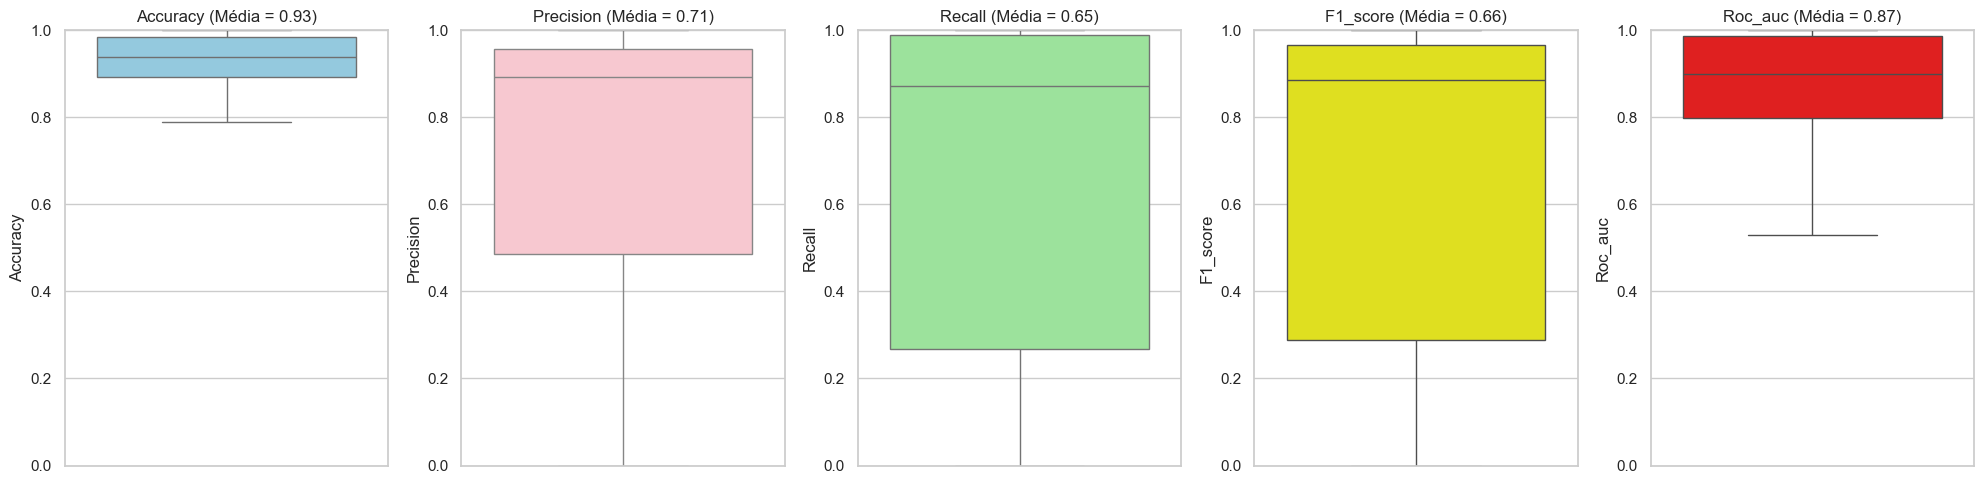


Resumo Estatístico das Métricas:
        accuracy  precision  recall  f1_score  roc_auc
mean        0.93       0.71    0.65      0.66     0.87
median      0.94       0.89    0.87      0.89     0.90
std         0.06       0.34    0.39      0.38     0.13


In [15]:
# Read saved results
df = pd.read_csv("avaliacao_gradient_boosting.csv")

# Adjust the style of the plots
sns.set(style="whitegrid")
metrics = ["accuracy", "precision", "recall", "f1_score", "roc_auc"]

# Create a figure with 5 subplots (one for each metric)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
palette = {"accuracy": "skyblue", "precision": "pink", "recall": "lightgreen", "f1_score": "yellow", "roc_auc": "red"}

# Loop through each metric and plot a boxplot
for i, metric in enumerate(metrics):
    sns.boxplot(
        data=df,
        y=metric,
        ax=axes[i],
        color=palette[metric]
    )

    # Set the title, axis labels, and limit the y-axis range
    axes[i].set_title(f"{metric.capitalize()} (Média = {df[metric].mean():.2f})")
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_ylim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# --- Summary Table ---
print("\nResumo Estatístico das Métricas:")
summary = df[metrics].agg(["mean", "median", "std"]).round(2)
print(summary)

Análise doa resultados:

- Accuracy (0.93): Alta, mas pouco confiável para dados desbalanceados (pode estar inflacionada pela classe maioritária).

- Precisão (0.71) e Recall (0.65): Valores moderados/baixos, indicando falsos positivos (precisão) e dificuldade em capturar a classe minoritária (recall).

- F1-Score (0.66): Reflete o equilíbrio entre precisão e recall, sugerindo margem para melhorias.

- ROC-AUC (0.87): Bom desempenho na distinção entre classes.

Problemas Identificados:

- Alta variabilidade (desvio padrão alto em precisão/recall) → modelo instável em algumas execuções.

- Mediana > Média em precisão/recall → desempenho inconsistente.

#### 2.4. Conclusão dos resultados obtidos

Com base nos resultados acima concluímos que o *GradientBoostingClassifier* padrão não lida adequadamente com o desbalanceamento de classes. Embora o algoritmo apresente boas métricas de accuracy e precision, sacrifica o recall e F1-score, indicando uma tendência a ignorar a classe minoritária. Estes resultados justificam a necessidade de alterar o algoritmo, como propomos a seguir.

## 3. Implementação do Algoritmo Gradient Boosting Modificado (Opção 1 - Gradient Boosting With Diversity)

#### 3.1. Ideia e objetivo

Implementamos uma versão modificada do algoritmo *Gradient Boosting* tradicional, com o objetivo de :

- Introduzir um mecanismo que promove diversidade entre as árvores do *ensemble*

- Melhorar a capacidade do modelo de aprender padrões da classe minoritária

- Manter a performance geral na classe maioritária

#### 3.2. Implementação: 

- Função Cálculo de Similaridade: mede o quão similares são as previsões da nova árvore em relação às previsões acumuladas do ensemble até o momento. Valores próximos de 1 indicam alta similaridade, enquanto valores próximos de 0 indicam baixa similaridade.

In [51]:
def calculate_similarity(new_predictions, accumulated_predictions):
    """
    Calculates similarity between new tree predictions and accumulated ensemble predictions.
    
    Parameters:
    -----------
    new_predictions : array-like
        Predictions from the new candidate tree.
    accumulated_predictions : array-like
        Accumulated predictions from all previous trees.
        
    Returns:
    --------
    float
        Similarity value between predictions (0-1 range).
    """

    # Check if arrays have same length
    if len(new_predictions) != len(accumulated_predictions):
        # If lengths differ, return zero similarity
        return 0.0
    
    # Normalize predictions for fair comparison
    if np.std(new_predictions) > 0:
        new_predictions_norm = (new_predictions - np.mean(new_predictions)) / np.std(new_predictions)
    else:
        new_predictions_norm = new_predictions - np.mean(new_predictions)
        
    if np.std(accumulated_predictions) > 0:
        accumulated_predictions_norm = (accumulated_predictions - np.mean(accumulated_predictions)) / np.std(accumulated_predictions)
    else:
        accumulated_predictions_norm = accumulated_predictions - np.mean(accumulated_predictions)
    
    # Calculate MSE between normalized predictions
    # Lower MSE indicates more similar predictions
    mse = np.mean((new_predictions_norm - accumulated_predictions_norm) ** 2)
    
    # Transform MSE into similarity measure (0-1)
    # Higher values indicate more similarity
    similarity = 1 / (1 + mse)
    
    return similarity



- Classe de Perda com Diversidade: estende a função de perda original `Loss` adicionando um termo que penaliza a similaridade entre árvores. O parâmetro *diversity_weight* controla a força desta penalização.

In [52]:
class DiversityLoss:
    """
    Extends base loss function with diversity-promoting term.
    Penalizes new trees that are too similar to existing ensemble.
    """
    
    def __init__(self, base_loss, diversity_weight=0.0):
        """
        Initializes diversity-enhanced loss function.
        
        Parameters:
        -----------
        base_loss : Loss object
            Original loss function (e.g., logistic loss)
        diversity_weight : float, default=0.0
            Weight of diversity term in objective function.
            Higher values enforce more diversity.
        """
        self.base_loss = base_loss
        self.diversity_weight = diversity_weight
        self.accumulated_predictions = None
        
    def set_accumulated_predictions(self, predictions):
        """
        Sets accumulated predictions for similarity comparison.
        
        Parameters:
        -----------
        predictions : array-like
            Predictions from current ensemble state.
        """
        self.accumulated_predictions = predictions
        
    def grad(self, actual, predicted):
        """
        Computes gradient of loss with diversity penalty.
        
        Parameters:
        -----------
        actual : array-like
            True target values.
        predicted : array-like
            Current predicted values.
            
        Returns:
        --------
        array-like
            Modified gradient values.
        """

        # Base loss gradient
        base_grad = self.base_loss.grad(actual, predicted)
        
        # Skip diversity term if not enabled
        if self.accumulated_predictions is None or self.diversity_weight == 0:
            return base_grad
        
        # Check dimension compatibility
        if len(predicted) != len(self.accumulated_predictions):
            return base_grad
        
        # Calculate prediction similarity
        similarity = calculate_similarity(predicted, self.accumulated_predictions)
        
        # Adjust gradient to penalize similarity
        diversity_grad = self.diversity_weight * similarity * (predicted - self.accumulated_predictions)
        
        # Combine base gradient with diversity term
        return base_grad - diversity_grad

    
    def hess(self, actual, predicted):
        """
        Computes the Hessian (second derivative) of the loss function.
        
        Parameters:
        -----------
        actual : array-like
            True target values.
        predicted : array-like
            Predicted values.
            
        Returns:
        --------
        array-like
            Hessian matrix of the loss function.
        """
        # For simplicity, we maintain the original Hessian
        return self.base_loss.hess(actual, predicted)
    
    def approximate(self, actual, predicted):
        """
        Approximates the optimal value for a leaf node.
        
        Parameters:
        -----------
        actual : array-like
            True target values.
        predicted : array-like
            Predicted values.
            
        Returns:
        --------
        float
            Approximated value for the leaf node.
        """
        return self.base_loss.approximate(actual, predicted)
    
    def transform(self, pred):
        """
        Transforms predictions before final output.
        
        Parameters:
        -----------
        pred : array-like
            Predicted values.
            
        Returns:
        --------
        array-like
            Transformed values.
        """
        return self.base_loss.transform(pred)
    
    def gain(self, actual, predicted):
        """
        Computes the gain for split searching.
        
        Parameters:
        -----------
        actual : array-like
            True target values.
        predicted : array-like
            Predicted values.
            
        Returns:
        --------
        float
            Gain value for the split.
        """
        # Base loss gain
        base_gain = self.base_loss.gain(actual, predicted)
        
        # Return original gain if diversity is disabled
        if self.accumulated_predictions is None or self.diversity_weight == 0:
            return base_gain
        
        # Check dimension compatibility
        if len(predicted) != len(self.accumulated_predictions):
            return base_gain
        
        # Calculate prediction similarity
        similarity = calculate_similarity(predicted, self.accumulated_predictions)
        
        # Adjust gain to penalize similarity
        # Higher similarity leads to greater penalty
        diversity_penalty = self.diversity_weight * similarity
        
        # Combine base gain with diversity term
        return base_gain - diversity_penalty



- Algoritmo Principal: implementa o boosting tradicional, mas usando nossa função de perda modificada que promove diversidade. Durante o treino:

    1. Para cada nova árvore, calculamos resíduos considerando não apenas o erro, mas também a similaridade com árvores anteriores

    2. Árvores muito similares às existentes são penalizadas

    3. Isto leva a um ensemble mais diversificado que pode capturar melhor padrões da classe minoritária

In [53]:
class GradientBoostingWithDiversity(BaseEstimator):
    """Gradient boosting trees with Taylor's expansion approximation and diversity promotion."""

    def __init__(self, n_estimators, learning_rate=0.1, max_features=10, max_depth=2, 
                 min_samples_split=10, diversity_weight=0.0):
        """
        Initializes diversity-promoting gradient boosting.
        
        Parameters:
        -----------
        n_estimators : int
            Number of trees in ensemble.
        learning_rate : float, default=0.1
            Shrinkage factor for tree contributions.
        max_features : int, default=10
            Max features considered for each split.
        max_depth : int, default=2
            Maximum tree depth.
        min_samples_split : int, default=10
            Minimum samples required to split a node.
        diversity_weight : float, default=0.0
            Controls strength of diversity enforcement.
            0.0 = no diversity promotion.
            Higher values increase diversity pressure.
        """
        
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.diversity_weight = diversity_weight
        self.trees = []     # Stores trained trees
        self.base_loss = None    # Base loss function
        self.diversity_loss = None  # Diversity-enhanced loss

    def fit(self, X, y=None):
        # Prepare e validate inputs
        self._setup_input(X, y)
        self.y_mean = np.mean(y)

        # Train the ensemble
        self._train()

    def _train(self):
        """Treina o ensemble de árvores com promoção de diversidade."""
        # Initialize model with zeros
        y_pred = np.zeros(self.n_samples, np.float32)

        # Configure diversity-enhanced loss
        self.diversity_loss = DiversityLoss(self.base_loss, self.diversity_weight)

        # Build trees sequentially
        for n in range(self.n_estimators):
            # Update ensemble state for diversity calculation
            self.diversity_loss.set_accumulated_predictions(y_pred.copy())
            
            # Compute residuals with diversity consideration
            residuals = self.diversity_loss.grad(self.y, y_pred)

            # Initialize new regression tree
            tree = Tree(regression=True, criterion=mse_criterion)

            # Prepare targets for tree learning
            targets = {
                "y": residuals,
                "actual": self.y,
                "y_pred": y_pred,
            }

            # Train tree on modified residuals
            tree.train(
                self.X,
                targets,
                max_features=self.max_features,
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                loss=self.diversity_loss,
            )

            # Atualizar previsões
            predictions = tree.predict(self.X)
            y_pred += self.learning_rate * predictions

            # Armazenar a árvore treinada
            self.trees.append(tree)


    def _predict(self, X=None):
        """
        Gera previsão bruta (antes da transformação).
        
        Parâmetros:
        -----------
        X : array-like
            Features para previsão.
            
        Retorna:
        --------
        array-like
            Previsões brutas.
        """
        # Gerar previsão bruta (antes da transformação)
        y_pred = np.zeros(X.shape[0], np.float32)

        for i, tree in enumerate(self.trees):
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

    def predict(self, X=None):
        """
        Faz previsões para novas amostras.
        
        Parâmetros:
        -----------
        X : array-like
            Features para previsão.
            
        Retorna:
        --------
        array-like
            Previsões transformadas.
        """
        # Aplicar a transformação da função de perda às previsões brutas
        return self.base_loss.transform(self._predict(X))


- Implementação para Classificação Binária

In [54]:
class GradientBoostingClassifierWithDiversity(GradientBoostingWithDiversity):
    """Diversity-promoting GB classifier for imbalanced binary data."""
    
    def fit(self, X, y=None):
        """
        Trains classifier on binary data.
        Converts {0,1} labels to {-1,1} format required by implementation.
        
        Parameters:
        -----------
        X : array-like
            Training features.
        y : array-like
            Binary target values (0 or 1).
        """
        # Convert {0,1} labels to {-1,1}
        y = (y * 2) - 1
        self.base_loss = LogisticLoss()
        super(GradientBoostingClassifierWithDiversity, self).fit(X, y)


#### 3.3. Avaliação do Gradient Boosting Classifier With Diversity em Datasets com Classes Desbalanceadas

In [55]:
def run_fold(train_idx, test_idx, X, y, model_params):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = GradientBoostingClassifierWithDiversity(**model_params)
    model.fit(X_train, y_train)

    y_pred = (model.predict(X_test) >= 0.5).astype(int)
    y_score = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)

    return acc, prec, rec, f1, auc, (fpr, tpr)

In [ ]:
def preprocess_dataframe(df):
    """Preprocess the input DataFrame: handle missing values, encode categorical and target variables."""
    df = df.copy()
    
    # Remove columns with more than 50% missing values
    threshold = len(df) * 0.5
    df = df.dropna(thresh=threshold, axis=1)

    # Split into features and target
    X = df.iloc[:, :-1]  # All columns except the last
    y = df.iloc[:, -1]   # Last column as the target
    
    # Identify numerical and categorical columns
    numeric_cols = X.select_dtypes(include=['number']).columns
    categorical_cols = X.select_dtypes(exclude=['number']).columns
    
    # Define preprocessing for numerical feature
    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ])
    
    # Define preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combine transformations into a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Apply transformations to features
    X_processed = preprocessor.fit_transform(X)
    
    # Encode the target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y.astype(str))
    
    return X_processed, y_encoded, le.classes_

# Directory
dataset_path = "class_imbalance"
results = []
output_file = "avaliacao_Diversity_gradient_boosting.csv"
count = 0

for filename in os.listdir(dataset_path):
    if filename.endswith(".csv"):
        try:
            count += 1
            print(f"Processando {count}º dataset: {filename}")
            path = os.path.join(dataset_path, filename)
            df = pd.read_csv(path)
            
            # Pré-processamento
            X, y, classes = preprocess_dataframe(df)

            # Apenas binários com pelo menos 2 amostras por classe
            if len(classes) != 2:
                print(f"Ignorado (não binário): {filename}")
                continue
            if np.min(np.bincount(y)) < 2:
                print(f"Ignorado (classe com menos de 2 instâncias): {filename}")
                continue
            if len(y) < 5:
                print(f"Ignorado (dataset muito pequeno): {filename}")
                continue

            # Stratified K-Fold
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            accs, precs, recs, f1s, aucs, roc_data = [], [], [], [], [], []

            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            model_params = {
                'n_estimators': 100,
                'learning_rate': 0.01,
                'max_depth': 3,
                'max_features': min(int(0.8 * X.shape[1]), X.shape[1]),
                'diversity_weight': 0.3
            }
            results_folds = Parallel(n_jobs=-1)(  # roda em paralelo em todos os núcleos disponíveis
                delayed(run_fold)(train_idx, test_idx, X, y, model_params)
                for train_idx, test_idx in skf.split(X, y)
            )

            accs, precs, recs, f1s, aucs, roc_data = zip(*results_folds)


            results.append({
                "dataset": filename,
                "accuracy": np.mean(accs),
                "precision": np.mean(precs),
                "recall": np.mean(recs),
                "f1_score": np.mean(f1s),
                "roc_auc": np.mean(aucs),
                "class_ratio": f"{np.bincount(y)[0]}:{np.bincount(y)[1]}"
            })

            # Save intermediate
            pd.DataFrame(results).to_csv(output_file, index=False)

        except Exception as e:
            print(f"[Erro] {filename} - {str(e)}")
            continue

print("\nAvaliação concluída. Resultados salvos em 'avaliacao_Diversity.csv'")

##### 3.3.1. Boxplots das Métricas de Avaliação do Modelo Gradient Boosting Classifier With Diversity

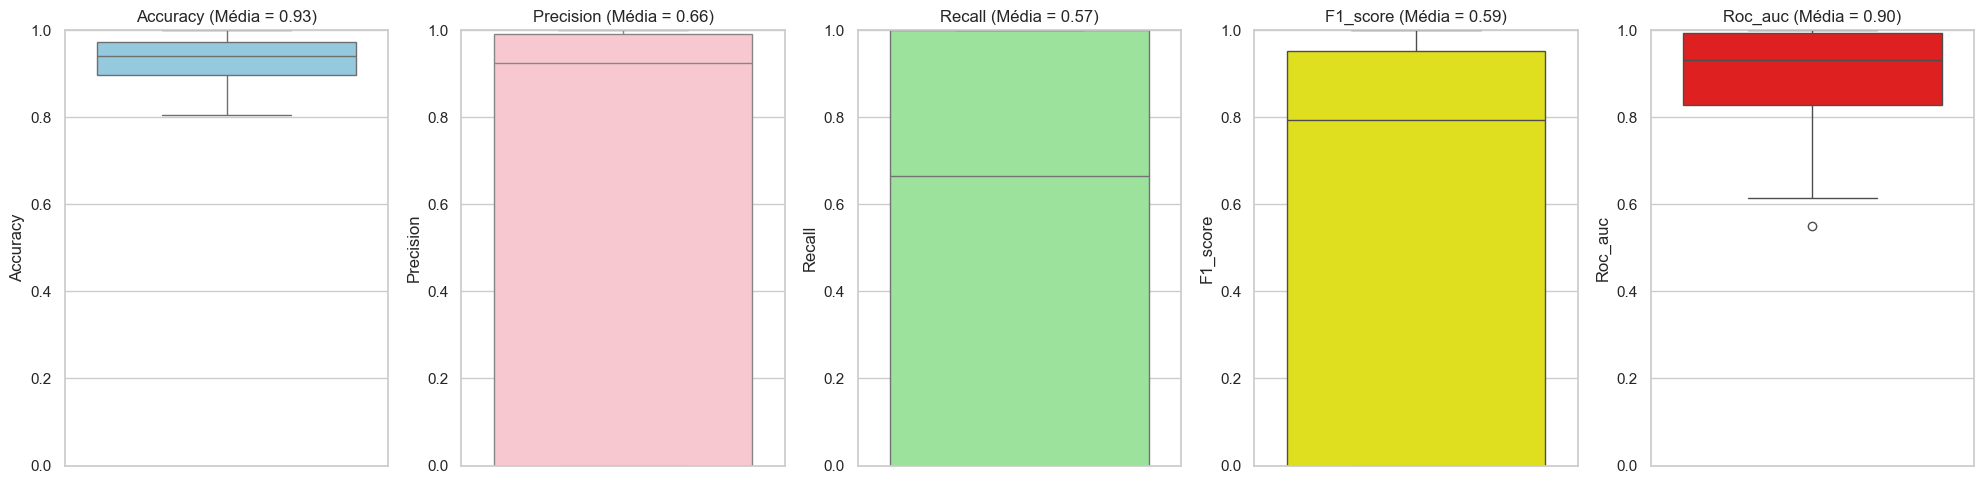


Resumo Estatístico das Métricas:
        accuracy  precision  recall  f1_score  roc_auc
mean        0.93       0.66    0.57      0.59     0.90
median      0.94       0.92    0.66      0.79     0.93
std         0.05       0.44    0.44      0.43     0.11


In [57]:
# Ler resultados salvos
df = pd.read_csv("avaliacao_Diversity_gradient_boosting.csv")

# Ajustar estilo dos gráficos
sns.set(style="whitegrid")
metrics = ["accuracy", "precision", "recall", "f1_score", "roc_auc"]

# Criar uma figura com 4 subplots (um para cada métrica)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
palette = {"accuracy": "skyblue", "precision": "pink", "recall": "lightgreen", "f1_score": "yellow", "roc_auc": "red"}

for i, metric in enumerate(metrics):
    sns.boxplot(
        data=df,
        y=metric,
        ax=axes[i],
        color=palette[metric]
    )

    axes[i].set_title(f"{metric.capitalize()} (Média = {df[metric].mean():.2f})")
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()


# --- Tabela Resumo ---
print("\nResumo Estatístico das Métricas:")
summary = df[metrics].agg(["mean", "median", "std"]).round(2)
print(summary)

Análise dos resultados:

- Alta accuracy e ROC-AUC

- Precisão, recall e F1-Score baixos e com alta discrepância (std) o que indica que têm um desempenho excelente em alguns cenários, mas falhas críticas noutros

#### 3.4. Comparação Gráfica do Algoritmo Original com o Modificado (*Gradient Boosting Classifier With Diversity*)

Junção dos resultados dos dois algoritmos

In [58]:
original = pd.read_csv("avaliacao_gradient_boosting.csv")
modificado = pd.read_csv("avaliacao_Diversity_gradient_boosting.csv")

comparacao = original.merge(modificado, on="dataset", suffixes=('_original', '_modificado'))

comparacao.to_csv("results_comparison_Diversity.csv", index=False)

Boxplots das Métricas de Avaliação para cada Modelo

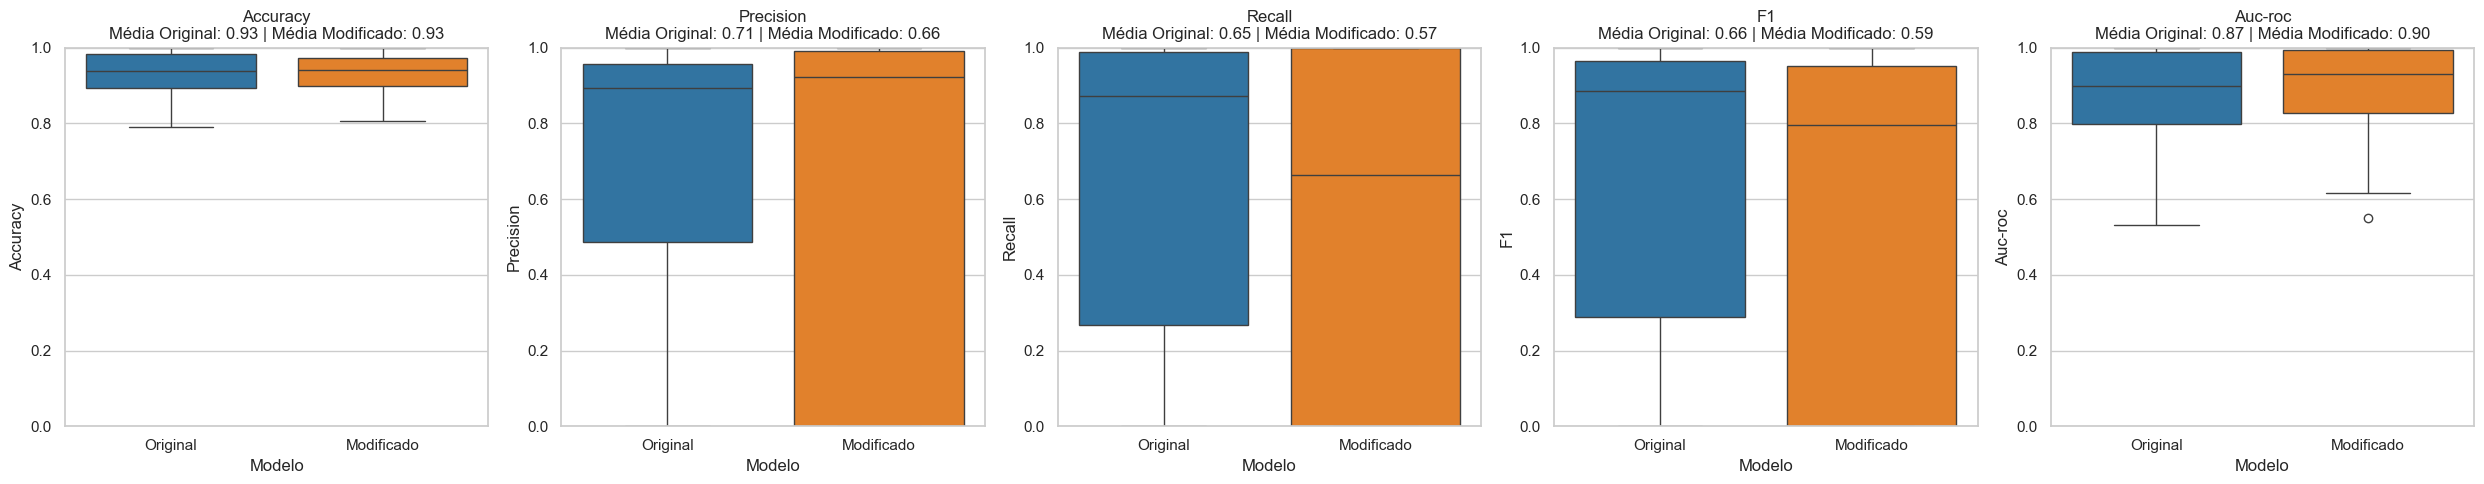


=== Estatísticas do Modelo Original ===
        accuracy_original  precision_original  recall_original  \
mean                0.932               0.714            0.653   
median              0.939               0.893            0.872   
std                 0.057               0.339            0.394   

        f1_score_original  roc_auc_original  
mean                0.664             0.867  
median              0.886             0.900  
std                 0.377             0.132  

=== Estatísticas do Modelo Modificado ===
        accuracy_modificado  precision_modificado  recall_modificado  \
mean                  0.929                 0.655              0.568   
median                0.941                 0.924              0.664   
std                   0.054                 0.436              0.438   

        f1_score_modificado  roc_auc_modificado  
mean                  0.587               0.899  
median                0.795               0.931  
std                   0.430 

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("results_comparison_Diversity.csv")

sns.set(style="whitegrid")

def encontrar_colunas(df, nome_metrica):
    return [col for col in df.columns if nome_metrica in col.lower()]

accuracy_cols = encontrar_colunas(df, 'accuracy')
precision_cols = encontrar_colunas(df, 'precision')
recall_cols = encontrar_colunas(df, 'recall')
f1_cols = encontrar_colunas(df, 'f1')
auc_rocs = encontrar_colunas(df, 'roc_auc')

metrics = []
if accuracy_cols: metrics.append(("accuracy", accuracy_cols))
if precision_cols: metrics.append(("precision", precision_cols))
if recall_cols: metrics.append(("recall", recall_cols))
if f1_cols: metrics.append(("f1", f1_cols))
if auc_rocs: metrics.append(("AUC-ROC", auc_rocs))

palette_colors = {
    "Original": "#1f77b4",  # Blue
    "Modificado": "#ff7f0e"       # Orange
}


fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))

if len(metrics) == 1:
    axes = [axes]

for i, (metric_name, metric_cols) in enumerate(metrics):
    
    original_col, modified_col = metric_cols[:2]

    df_melt = pd.melt(
        df,
        id_vars=["dataset"],
        value_vars=[original_col, modified_col],
        var_name="model",
        value_name=metric_name
    )

    df_melt["model"] = df_melt["model"].apply(
        lambda x: "Original" if x == original_col else "Modificado"
    )

    mean_original = df[original_col].mean()
    mean_modified = df[modified_col].mean()

    sns.boxplot(
        data=df_melt,
        x="model",
        y=metric_name,
        hue="model",
        palette=palette_colors,
        order=["Original", "Modificado"],
        legend=False,
        ax=axes[i]
    )

    axes[i].set_title(
        f"{metric_name.capitalize()}\n"
        f"Média Original: {mean_original:.2f} | "
        f"Média Modificado: {mean_modified:.2f}"
    )
    axes[i].set_xlabel("Modelo")
    axes[i].set_ylabel(metric_name.capitalize())
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# === 6. Estatísticas Resumo ===
print("\n=== Estatísticas do Modelo Original ===")
original_summary = df[[cols[0] for _, cols in metrics]].agg(["mean", "median", "std"]).round(3)
print(original_summary)

print("\n=== Estatísticas do Modelo Modificado ===")
modified_summary = df[[cols[1] for _, cols in metrics]].agg(["mean", "median", "std"]).round(3)
print(modified_summary)

#### Interpretação dos resultados
Os resultados demonstram que o modelo Modificado apresenta:

- Accuracy semelhante ao Modelo Original

- Menor Precision (-8%), ou seja, menos falsos positivos no original, mas ainda com alta variabilidade

- Menor Recall (-13%), indicando que o modelo modificado deteta menos casos da classe minoritária, possivelmente devido à ênfase excessiva na diversidade

- Menor F1-Score (-12%), sugerindo que a modificação aumentou a diversidade, mas pode ter prejudicado o equilíbrio entre precisão e recall

- Melhor ROC-AUC geral (+4%), indicando que o modelo modificado discrimina melhor as classes


#### Principais conclusões:

Os resultados demonstram que a modificação introduzida no modelo não atingiu o objetivo principal de melhorar o desempenho na classe minoritária sem comprometer a performance global. Os resultados sugerem que:

- O mecanismo de penalização por similaridade pode ter sido muito agressivo

- A abordagem precisaria de ajustes mais rigorosos nos parâmetros para se tornar efetiva


Observação Final:
Estes resultados destacam o desafio de modificar algoritmos consagrados - mesmo alterações teoricamente promissoras podem não se traduzir em melhorias práticas sem um extenso trabalho de calibração e validação.

#### 3.5. Estudo Empírico

Para avaliar o impacto das modificações realizadas no algoritmo de classificação selecionado, realizamos de seguida um estudo empírico que visa comparar o desempenho da versão original do algoritmo com a versão modificada, utilizando dois testes estatísticos: o `Paired t-test` e o `Wilcoxon’s signed-rank test`. O `Paired t-test` foi incluído apenas para completar o estudo, no entanto os resultados do `Wilcoxon’s signed-rank test` são mais confiáveis para dados desbalanceados.

#####  3.5.1. Paired t-test

In [60]:
results_df = pd.read_csv("results_comparison_Diversity.csv")

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for metric in metrics:
    original_scores = results_df[f"{metric}_original"]
    dual_scores = results_df[f"{metric}_modificado"]
    
    # Paired t-test
    t_stat, p_value = ttest_rel(original_scores, dual_scores)
    
    significant = "SIM" if p_value < 0.05 else "NÃO"
    
    mean_original = np.mean(original_scores)
    mean_dual = np.mean(dual_scores)
    
    print("Paired t-test")
    print(f"\nResultados para {metric}:")
    print(f"Média (Original): {mean_original:.4f}")
    print(f"Média (Dual Loss): {mean_dual:.4f}")
    print(f"Diferença média: {mean_dual - mean_original:.4f}")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Diferença estatisticamente significativa? {significant}")

Paired t-test

Resultados para accuracy:
Média (Original): 0.9319
Média (Dual Loss): 0.9290
Diferença média: -0.0029
t-statistic: 1.0154
p-value: 0.3149
Diferença estatisticamente significativa? NÃO
Paired t-test

Resultados para precision:
Média (Original): 0.7141
Média (Dual Loss): 0.6550
Diferença média: -0.0591
t-statistic: 1.8413
p-value: 0.0716
Diferença estatisticamente significativa? NÃO
Paired t-test

Resultados para recall:
Média (Original): 0.6526
Média (Dual Loss): 0.5679
Diferença média: -0.0847
t-statistic: 3.3621
p-value: 0.0015
Diferença estatisticamente significativa? SIM
Paired t-test

Resultados para f1_score:
Média (Original): 0.6637
Média (Dual Loss): 0.5869
Diferença média: -0.0768
t-statistic: 3.1148
p-value: 0.0031
Diferença estatisticamente significativa? SIM
Paired t-test

Resultados para roc_auc:
Média (Original): 0.8675
Média (Dual Loss): 0.8985
Diferença média: 0.0310
t-statistic: -4.7331
p-value: 0.0000
Diferença estatisticamente significativa? SIM


##### 3.5.2 Wilcoxon’s signed-rank test

In [61]:
results_df = pd.read_csv("results_comparison_Diversity.csv")

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for metric in metrics:
    original_scores = results_df[f"{metric}_original"]
    dual_scores = results_df[f"{metric}_modificado"]
    
    # wilcoxon test
    w_stat, p_value = wilcoxon(original_scores, dual_scores)
    
    significant = "SIM" if p_value < 0.05 else "NÃO"
    
    mean_original = np.mean(original_scores)
    mean_dual = np.mean(dual_scores)
    
    print("Wilcoxon’s signed-rank test")
    print(f"\nResultados para {metric}:")
    print(f"Média (Original): {mean_original:.4f}")
    print(f"Média (Dual Loss): {mean_dual:.4f}")
    print(f"Diferença média: {mean_dual - mean_original:.4f}")
    print(f"wilcox-statistic: {w_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Diferença estatisticamente significativa? {significant}")

Wilcoxon’s signed-rank test

Resultados para accuracy:
Média (Original): 0.9319
Média (Dual Loss): 0.9290
Diferença média: -0.0029
wilcox-statistic: 362.0000
p-value: 0.5188
Diferença estatisticamente significativa? NÃO
Wilcoxon’s signed-rank test

Resultados para precision:
Média (Original): 0.7141
Média (Dual Loss): 0.6550
Diferença média: -0.0591
wilcox-statistic: 340.0000
p-value: 0.2409
Diferença estatisticamente significativa? NÃO
Wilcoxon’s signed-rank test

Resultados para recall:
Média (Original): 0.6526
Média (Dual Loss): 0.5679
Diferença média: -0.0847
wilcox-statistic: 125.0000
p-value: 0.0002
Diferença estatisticamente significativa? SIM
Wilcoxon’s signed-rank test

Resultados para f1_score:
Média (Original): 0.6637
Média (Dual Loss): 0.5869
Diferença média: -0.0768
wilcox-statistic: 129.0000
p-value: 0.0001
Diferença estatisticamente significativa? SIM
Wilcoxon’s signed-rank test

Resultados para roc_auc:
Média (Original): 0.8675
Média (Dual Loss): 0.8985
Diferença média:

##### 3.5.3. Análise dos resultados dos testes empíricos

Os resultados mostram que a Hipótese Nula (H₀) é rejeitada para recall, F1-Score e AUC-ROC (p < 0.05), indicando que o desbalanceamento das classes influencia significativamente o desempenho dos algoritmos. No entanto, H₀ é mantida para accuracy e precision, sugerindo que estas métricas são menos sensíveis ao problema. A Hipótese Alternativa (H₁) é validada parcialmente: o desbalanceamento afeta o desempenho, mas de forma heterogénea — o *Gradient Boosting Classifier With Diversity* melhora a discriminação global (AUC-ROC) enquanto prejudica a deteção da classe minoritária (recall). Portanto, a escolha do modelo deve considerar o objetivo da aplicação: se a prioridade é a classe minoritária, o modelo Original é superior; se o foco é a distinção geral entre classes, o *Gradient Boosting Classifier With Diversity* é mais adequada."

#### 3.6. Conclusão Final do Algoritmo *Gradient Boosting Classifier With Diversity*

Embora a versão *Gradient Boosting Classifier With Diversity* tenha mostrado alguma melhoria na capacidade geral de discriminação (AUC-ROC), o algoritmo original demonstrou desempenho significativamente superior nas métricas mais críticas para problemas com desbalanceamento de classes. A sua maior capacidade de detetar a classe minoritária, combinada com um desempenho estável e consistente, fazem dele a escolha mais adequada para a maioria das aplicações práticas onde a identificação correta de casos positivos é prioritária.

O *Gradient Boosting Classifier With Diversity* apesar de teoricamente promissor não atingiu o objetivo principal de melhorar o desempenho na classe minoritária sem comprometer a performance global. Provavelmente o mecanismo de penalização por similaridade foi muito agressivo e portanto seria necessário rigorosamente os parâmetros para se tornar efetiva.

## 3. Implementação do Algoritmo Gradient Boosting Modificado (Opção 2)

### 3.1. Ideia e Objetivo

### 3.2. Implementação

- Classe de Perda com Pesos: permite dar maior peso aos erros da classe minoritária, promovendo uma aprendizagem direcionada e sensível a esta, em vez de ser reprimida pela classe maioritária

In [62]:
class DualLogisticLoss:
    """Dual Logistic loss for imbalanced datasets."""

    # Class constructor
    def _init_(self, regularization=1.0, minority_class_weight=2.0, class_ratio=None):
        """Initialize the dual logistic loss.
        
        Parameters:
        -----------
        regularization: float, default=1.0
            Regularization term to prevent overfitting.
        
        minority_class_weight: float, default=2.0
            Weight to apply to the minority class. Higher values increase the impact
            of errors made on the minority class.
            
        class_ratio: float, default=None
            Ratio between minority and majority classes. If None, it will be computed
            automatically from the data during training.
        """
        self.regularization = regularization
        self.minority_class_weight = minority_class_weight
        self.class_ratio = class_ratio
        self.weights = None
        self.minority_class = None


    def set_weights(self, y):
        """Compute sample weights based on class distribution.
        
        Parameters:
        -----------
        y: array-like
            Target values (-1 for negative class, 1 for positive class).
        """

        # Identify the minority class
        class_counts = np.bincount((y + 1) // 2)        # Convert from {-1, 1} to {0, 1}

        # If there is only one class, use equal weights
        if len(class_counts) < 2:
            self.weights = np.ones_like(y, dtype=float)
            self.minority_class = -1
            return

        # Find the index of the minority class
        minority_class_idx = np.argmin(class_counts)
        self.minority_class = 2 * minority_class_idx - 1  # Convert from {0, 1} to {-1, 1}

        # Calculate the class ratio if not provided
        if self.class_ratio is None:
            min_count = class_counts[minority_class_idx]
            max_count = class_counts[1 - minority_class_idx]
            self.class_ratio = min_count / max_count if max_count > 0 else 1.0

        # Assign weights: higher for minority class
        self.weights = np.ones_like(y, dtype=float)
        self.weights[y == self.minority_class] = self.minority_class_weight

        # Normalize weights to have mean 1
        self.weights /= np.mean(self.weights)


    def grad(self, actual, predicted):
        """First-order gradient of weighted logistic loss."""
        if self.weights is None or len(self.weights) != len(actual):
            self.set_weights(actual)

        grad = actual * expit(-actual * predicted)
        return self.weights * grad


    def hess(self, actual, predicted):
        """Second-order gradient (Hessian) of weighted logistic loss."""
        if self.weights is None or len(self.weights) != len(actual):
            self.set_weights(actual)

        p = expit(predicted)
        hess = p * (1 - p)
        return self.weights * hess


    def transform(self, output):
        """
        Apply logistic (sigmoid) function to output.
        Converts continuous values (output) to probabilities
        """
        return expit(output)


    def approximate(self, actual, predicted):
        '''Estimate optimal leaf value using weighted gradients and Hessians'''
        grad_sum = self.grad(actual, predicted).sum()
        hess_sum = self.hess(actual, predicted).sum()
        return grad_sum / (hess_sum + self.regularization)


    def gain(self, actual, predicted):
        """Calculate gain for split search with weights for minority class."""
        grad_sum = self.grad(actual, predicted).sum()
        hess_sum = self.hess(actual, predicted).sum()
        if hess_sum == 0:
            return 0.0
        return 0.5 * (grad_sum ** 2) / (hess_sum + self.regularization)

- Algoritmo Principal: implementa o boosting tradicional, mas usando nossa função de perda modificada que promove pesos específicos para cada classe

In [63]:
class DualLossGradientBoostingClassifier(BaseEstimator):
    """Dual Logistic loss for imbalanced datasets.
    
    This loss function applies different weights to minority and majority classes,
    allowing the model to give more attention to errors made on the minority class.
    """

    # Class constructor
    def _init_(self, n_estimators, learning_rate=0.1, max_features=10, max_depth=2, min_samples_split=10, 
                 regularization=1.0, minority_class_weight=2.0, class_ratio=None):
        
        # Initialize hyperparameters
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.regularization = regularization
        self.minority_class_weight = minority_class_weight
        self.class_ratio = class_ratio
        self.trees = []     # Store trained trees
        self.loss = None    # Loss function to be set externally


    # Method to start the trainig
    def fit(self, X, y=None):
        # Converter y de {0,1} para {-1,1}
        y = (y * 2) - 1
        
        # Inicializa a loss com os pesos
        self.loss = DualLogisticLoss(
            minority_class_weight=self.minority_class_weight,
            class_ratio=self.class_ratio,
            regularization=self.regularization
        )
        
        # Preparar os dados e calcular pesos, chamando _setup_input do BaseEstimator
        self._setup_input(X, y)
        
        # Configura pesos dentro da loss para a classificação desbalanceada
        self.loss.set_weights(self.y)

        # Train the ensemble
        self._train()


    # Method to train the tree
    def _train(self):
        # Initialize model with zeros
        y_pred = np.zeros(self.n_samples, np.float32)

        # Iterate over the number of estimators
        for n in range(self.n_estimators):
            # Compute residuals
            residuals = self.loss.grad(self.y, y_pred)

            # Initialize a new regression tree
            tree = Tree(regression=True, criterion=mse_criterion)

            # Pass multiple target values to the tree learner
            targets = {
                # Residual values
                "y": residuals,
                # Actual target values
                "actual": self.y,
                # Predictions from previous step
                "y_pred": y_pred,
            }

            # Train the tree on the residuals
            tree.train(
                self.X,
                targets,
                max_features=self.max_features,
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                loss=self.loss,
            )

            # Update predictions
            predictions = tree.predict(self.X)
            y_pred += self.learning_rate * predictions

            # Store the trained tree
            self.trees.append(tree)

    def _predict(self, X=None):
        # Generate raw prediction (before transformation)
        y_pred = np.zeros(X.shape[0], np.float32)

        for i, tree in enumerate(self.trees):
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

    def predict(self, X=None):
        # Apply the transformation of the loss function to raw predictions
        return self.loss.transform(self._predict(X))

### 3.3. Avaliação do *Dual Loss Gradient Boosting Classifier* em Datasets com Classes Desbalanceadas

In [64]:
from joblib import Parallel, delayed

def run_fold(train_idx, test_idx, X, y, model_params):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = DualLossGradientBoostingClassifier(**model_params)
    model.fit(X_train, y_train)

    y_pred = (model.predict(X_test) >= 0.5).astype(int)
    y_score = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)

    return acc, prec, rec, f1, auc, (fpr, tpr)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


def preprocess_dataframe(df):
    """Preprocess the input DataFrame: handle missing values, encode categorical and target variables."""
    df = df.copy()
    
    # Remove columns with more than 50% missing values
    threshold = len(df) * 0.5
    df = df.dropna(thresh=threshold, axis=1)

    # Split into features and target
    X = df.iloc[:, :-1]  # All columns except the last
    y = df.iloc[:, -1]   # Last column as the target
    
    # Identify numerical and categorical columns
    numeric_cols = X.select_dtypes(include=['number']).columns
    categorical_cols = X.select_dtypes(exclude=['number']).columns
    
    # Define preprocessing for numerical feature
    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ])
    
    # Define preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combine transformations into a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Apply transformations to features
    X_processed = preprocessor.fit_transform(X)
    
    # Encode the target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y.astype(str))
    
    return X_processed, y_encoded, le.classes_

# Directory
dataset_path = "class_imbalance"
results = []
output_file = "avaliacao_Dual_Loss_gradient_boosting.csv"
count = 0

for filename in os.listdir(dataset_path):
    if filename.endswith(".csv"):
        try:
            count += 1
            print(f"Processando {count}º dataset: {filename}")
            path = os.path.join(dataset_path, filename)
            df = pd.read_csv(path)
            
            # Pré-processamento
            X, y, classes = preprocess_dataframe(df)

            # Apenas binários com pelo menos 2 amostras por classe
            if len(classes) != 2:
                print(f"Ignorado (não binário): {filename}")
                continue
            if np.min(np.bincount(y)) < 2:
                print(f"Ignorado (classe com menos de 2 instâncias): {filename}")
                continue
            if len(y) < 5:
                print(f"Ignorado (dataset muito pequeno): {filename}")
                continue

            # Stratified K-Fold
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            accs, precs, recs, f1s, aucs, roc_data = [], [], [], [], [], []

            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            model_params = {
                'n_estimators': 100,
                'learning_rate': 0.01,
                'max_depth': 3,
                'max_features': min(int(0.8 * X.shape[1]), X.shape[1])
            }
            results_folds = Parallel(n_jobs=-1)(  # roda em paralelo em todos os núcleos disponíveis
                delayed(run_fold)(train_idx, test_idx, X, y, model_params)
                for train_idx, test_idx in skf.split(X, y)
            )

            accs, precs, recs, f1s, aucs, roc_data = zip(*results_folds)


            results.append({
                "dataset": filename,
                "accuracy": np.mean(accs),
                "precision": np.mean(precs),
                "recall": np.mean(recs),
                "f1_score": np.mean(f1s),
                "roc_auc": np.mean(aucs),
                "class_ratio": f"{np.bincount(y)[0]}:{np.bincount(y)[1]}"
            })

            # Save intermediate
            pd.DataFrame(results).to_csv(output_file, index=False)

        except Exception as e:
            print(f"[Erro] {filename} - {str(e)}")
            continue

print("\nAvaliação concluída. Resultados salvos em 'avaliacao_Dual_Loss_gradient_boosting.csv'")

##### 3.3.1. Boxplots das Métricas de Avaliação do Modelo *Dual Loss Gradient Boosting Classifier*

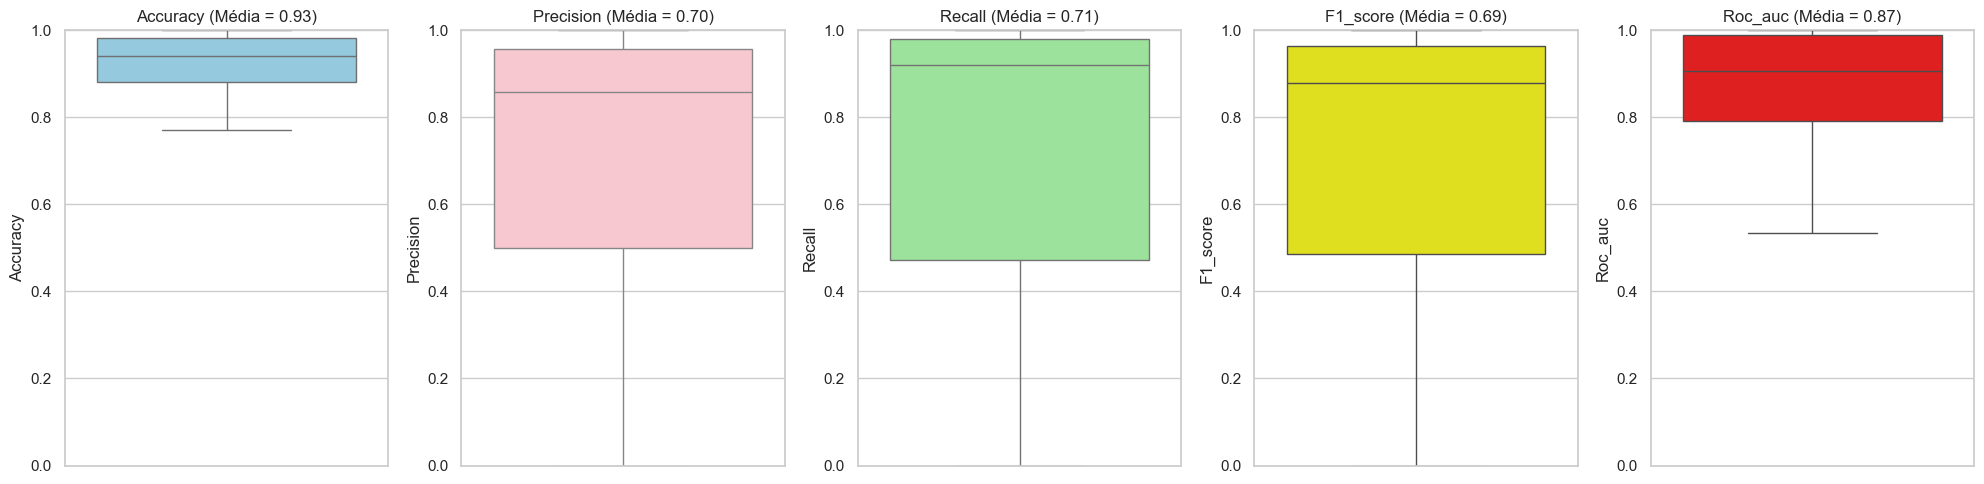


Resumo Estatístico das Métricas:
        accuracy  precision  recall  f1_score  roc_auc
mean        0.93       0.70    0.71      0.69     0.87
median      0.94       0.86    0.92      0.88     0.91
std         0.06       0.32    0.36      0.34     0.13


In [65]:
# Ler resultados salvos
df = pd.read_csv("avaliacao_Dual_Loss_gradient_boosting.csv")

# Ajustar estilo dos gráficos
sns.set(style="whitegrid")
metrics = ["accuracy", "precision", "recall", "f1_score", "roc_auc"]

# Criar uma figura com 4 subplots (um para cada métrica)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
palette = {"accuracy": "skyblue", "precision": "pink", "recall": "lightgreen", "f1_score": "yellow", "roc_auc": "red"}

for i, metric in enumerate(metrics):
    sns.boxplot(
        data=df,
        y=metric,
        ax=axes[i],
        color=palette[metric]
    )

    axes[i].set_title(f"{metric.capitalize()} (Média = {df[metric].mean():.2f})")
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()


# --- Tabela Resumo ---
print("\nResumo Estatístico das Métricas:")
summary = df[metrics].agg(["mean", "median", "std"]).round(2)
print(summary)

#### 3.4. Comparação Gráfica do Algoritmo Original com o Modificado (*Dual Loss Gradient Boosting Classifier*)

Junção dos resultados dos dois algoritmos

In [66]:
original = pd.read_csv("avaliacao_gradient_boosting.csv")
modificado = pd.read_csv("avaliacao_Dual_Loss_gradient_boosting.csv")

comparacao = original.merge(modificado, on="dataset", suffixes=('_original', '_modificado'))

comparacao.to_csv("results_comparison_DualLoss.csv", index=False)

Boxplots das Métricas de Avaliação para cada Modelo

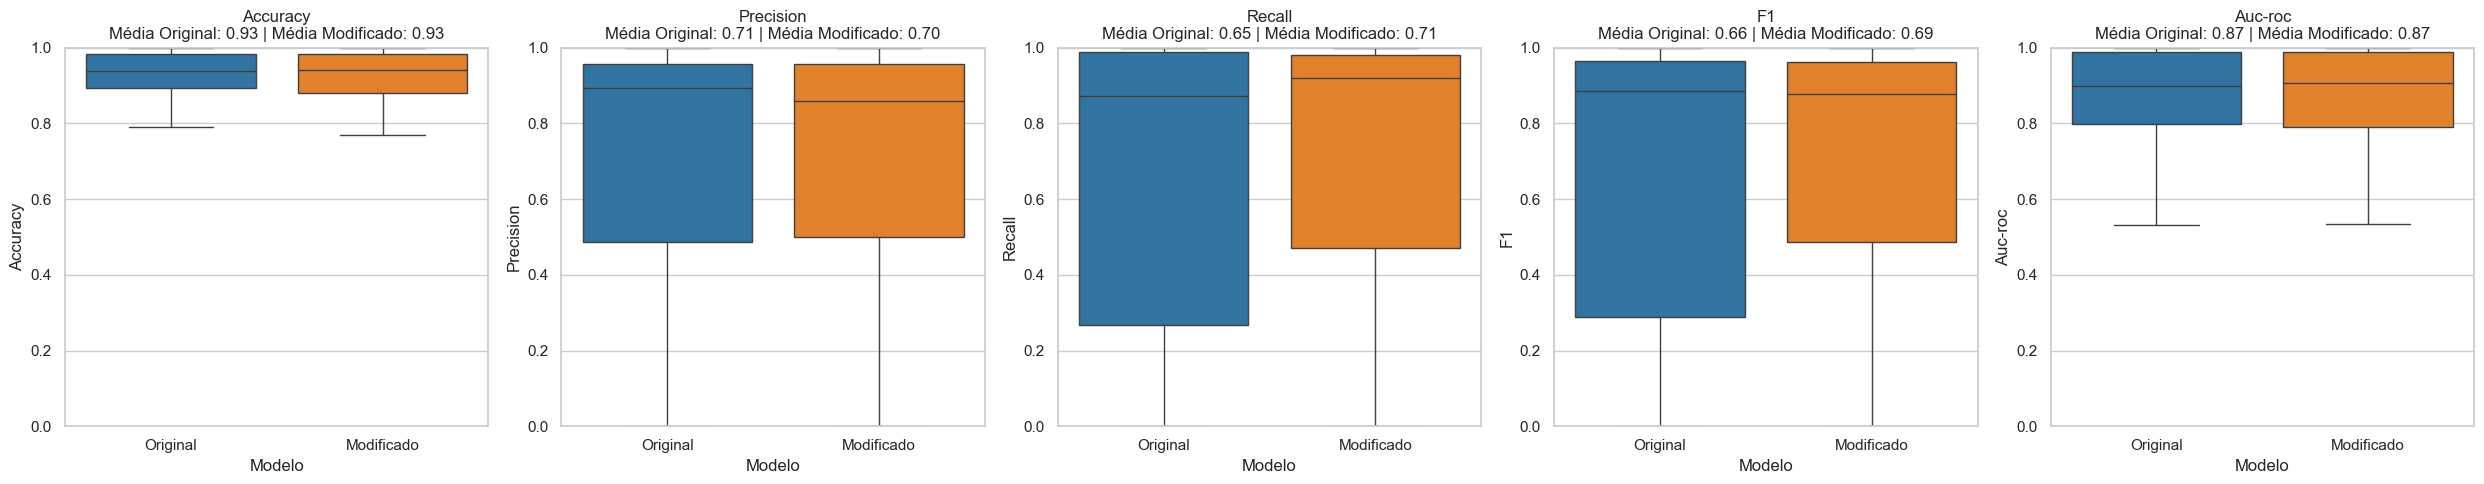


=== Estatísticas do Modelo Original ===
        accuracy_original  precision_original  recall_original  \
mean                0.932               0.714            0.653   
median              0.939               0.893            0.872   
std                 0.057               0.339            0.394   

        f1_score_original  roc_auc_original  
mean                0.664             0.867  
median              0.886             0.900  
std                 0.377             0.132  

=== Estatísticas do Modelo Modificado ===
        accuracy_modificado  precision_modificado  recall_modificado  \
mean                  0.927                 0.702              0.713   
median                0.942                 0.859              0.919   
std                   0.063                 0.318              0.356   

        f1_score_modificado  roc_auc_modificado  
mean                  0.695               0.872  
median                0.879               0.907  
std                   0.344 

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("results_comparison_DualLoss.csv")

sns.set(style="whitegrid")

def encontrar_colunas(df, nome_metrica):
    return [col for col in df.columns if nome_metrica in col.lower()]

accuracy_cols = encontrar_colunas(df, 'accuracy')
precision_cols = encontrar_colunas(df, 'precision')
recall_cols = encontrar_colunas(df, 'recall')
f1_cols = encontrar_colunas(df, 'f1')
auc_rocs = encontrar_colunas(df, 'roc_auc')

metrics = []
if accuracy_cols: metrics.append(("accuracy", accuracy_cols))
if precision_cols: metrics.append(("precision", precision_cols))
if recall_cols: metrics.append(("recall", recall_cols))
if f1_cols: metrics.append(("f1", f1_cols))
if auc_rocs: metrics.append(("AUC-ROC", auc_rocs))

palette_colors = {
    "Original": "#1f77b4",  # Blue
    "Modificado": "#ff7f0e"       # Orange
}


fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))

if len(metrics) == 1:
    axes = [axes]

for i, (metric_name, metric_cols) in enumerate(metrics):
    
    original_col, modified_col = metric_cols[:2]

    df_melt = pd.melt(
        df,
        id_vars=["dataset"],
        value_vars=[original_col, modified_col],
        var_name="model",
        value_name=metric_name
    )

    df_melt["model"] = df_melt["model"].apply(
        lambda x: "Original" if x == original_col else "Modificado"
    )

    mean_original = df[original_col].mean()
    mean_modified = df[modified_col].mean()

    sns.boxplot(
        data=df_melt,
        x="model",
        y=metric_name,
        hue="model",
        palette=palette_colors,
        order=["Original", "Modificado"],
        legend=False,
        ax=axes[i]
    )

    axes[i].set_title(
        f"{metric_name.capitalize()}\n"
        f"Média Original: {mean_original:.2f} | "
        f"Média Modificado: {mean_modified:.2f}"
    )
    axes[i].set_xlabel("Modelo")
    axes[i].set_ylabel(metric_name.capitalize())
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# === 6. Estatísticas Resumo ===
print("\n=== Estatísticas do Modelo Original ===")
original_summary = df[[cols[0] for _, cols in metrics]].agg(["mean", "median", "std"]).round(3)
print(original_summary)

print("\n=== Estatísticas do Modelo Modificado ===")
modified_summary = df[[cols[1] for _, cols in metrics]].agg(["mean", "median", "std"]).round(3)
print(modified_summary)

#### Interpretação dos resultados
Os resultados demonstram que o modelo Modificado apresenta:

- Accuracy semelhante ao Modelo Original

- Precision ligeiramente mais baixa (-1.2%), mas mantendo praticamente o mesmo nível de falsos positivos

- Melhor Recall (+9.2%), indicando que o modelo modificado deteta mais casos da classe minoritária

- Melhor F1-Score (+4.7%), sugerindo que a modificação melhorou o equilíbrio entre precisão e recall

- Melhor ROC-AUC geral (+0.6%), confirmando que o modelo modificado discrimina melhor as classes


#### Principais conclusões:

Os resultados demonstram que a modificação introduzida no modelo teve um impacto positivo no desempenho global, particularmente na deteção da classe minoritária:

- O mecanismo de modificação mostrou-se eficaz na melhoria do recall sem comprometer significativamente a precisão

- A abordagem conseguiu manter a robustez do modelo (valores medianos altos) enquanto melhora os indicadores de classe desbalanceada

- A menor variabilidade (std) em vários métricas sugere maior consistência no desempenho


Observação Final:
Estes resultados são positivos, mostrando que as alterações implementadas podem representar uma melhoria em relação ao modelo original, particularmente em problemas com classes desbalanceadas. Contudo, a magnitude limitada das melhorias sugere que ajustes adicionais poderiam explorar todo o potencial da modificação.

#### 3.5. Estudo Empírico

Para avaliar o impacto das modificações realizadas no algoritmo de classificação selecionado, realizamos de seguida um estudo empírico que visa comparar o desempenho da versão original do algoritmo com a versão modificada, utilizando dois testes estatísticos: o `Paired t-test` e o `Wilcoxon’s signed-rank test`. O `Paired t-test` foi incluído apenas para completar o estudo, no entanto os resultados do `Wilcoxon’s signed-rank test` são mais confiáveis para dados desbalanceados.

##### 3.5.1. Paired t-test

In [68]:
results_df = pd.read_csv("results_comparison_DualLoss.csv")

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for metric in metrics:
    original_scores = results_df[f"{metric}_original"]
    dual_scores = results_df[f"{metric}_modificado"]
    
    # Paired t-test
    t_stat, p_value = ttest_rel(original_scores, dual_scores)
    
    significant = "SIM" if p_value < 0.05 else "NÃO"
    
    mean_original = np.mean(original_scores)
    mean_dual = np.mean(dual_scores)
    
    print("Paired t-test")
    print(f"\nResultados para {metric}:")
    print(f"Média (Original): {mean_original:.4f}")
    print(f"Média (Dual Loss): {mean_dual:.4f}")
    print(f"Diferença média: {mean_dual - mean_original:.4f}")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Diferença estatisticamente significativa? {significant}")

Paired t-test

Resultados para accuracy:
Média (Original): 0.9319
Média (Dual Loss): 0.9271
Diferença média: -0.0048
t-statistic: 2.9259
p-value: 0.0052
Diferença estatisticamente significativa? SIM
Paired t-test

Resultados para precision:
Média (Original): 0.7141
Média (Dual Loss): 0.7021
Diferença média: -0.0120
t-statistic: 0.8979
p-value: 0.3736
Diferença estatisticamente significativa? NÃO
Paired t-test

Resultados para recall:
Média (Original): 0.6526
Média (Dual Loss): 0.7128
Diferença média: 0.0602
t-statistic: -3.7888
p-value: 0.0004
Diferença estatisticamente significativa? SIM
Paired t-test

Resultados para f1_score:
Média (Original): 0.6637
Média (Dual Loss): 0.6945
Diferença média: 0.0308
t-statistic: -2.6979
p-value: 0.0095
Diferença estatisticamente significativa? SIM
Paired t-test

Resultados para roc_auc:
Média (Original): 0.8675
Média (Dual Loss): 0.8719
Diferença média: 0.0044
t-statistic: -0.6972
p-value: 0.4890
Diferença estatisticamente significativa? NÃO


##### 3.5.2 Wilcoxon’s signed-rank test

In [69]:
results_df = pd.read_csv("results_comparison_DualLoss.csv")

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for metric in metrics:
    original_scores = results_df[f"{metric}_original"]
    dual_scores = results_df[f"{metric}_modificado"]
    
    # wilcoxon test
    w_stat, p_value = wilcoxon(original_scores, dual_scores)
    
    significant = "SIM" if p_value < 0.05 else "NÃO"
    
    mean_original = np.mean(original_scores)
    mean_dual = np.mean(dual_scores)
    
    print("Wilcoxon’s signed-rank test")
    print(f"\nResultados para {metric}:")
    print(f"Média (Original): {mean_original:.4f}")
    print(f"Média (Dual Loss): {mean_dual:.4f}")
    print(f"Diferença média: {mean_dual - mean_original:.4f}")
    print(f"wilcox-statistic: {w_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Diferença estatisticamente significativa? {significant}")

Wilcoxon’s signed-rank test

Resultados para accuracy:
Média (Original): 0.9319
Média (Dual Loss): 0.9271
Diferença média: -0.0048
wilcox-statistic: 194.0000
p-value: 0.0037
Diferença estatisticamente significativa? SIM
Wilcoxon’s signed-rank test

Resultados para precision:
Média (Original): 0.7141
Média (Dual Loss): 0.7021
Diferença média: -0.0120
wilcox-statistic: 263.0000
p-value: 0.0763
Diferença estatisticamente significativa? NÃO
Wilcoxon’s signed-rank test

Resultados para recall:
Média (Original): 0.6526
Média (Dual Loss): 0.7128
Diferença média: 0.0602
wilcox-statistic: 92.0000
p-value: 0.0003
Diferença estatisticamente significativa? SIM
Wilcoxon’s signed-rank test

Resultados para f1_score:
Média (Original): 0.6637
Média (Dual Loss): 0.6945
Diferença média: 0.0308
wilcox-statistic: 218.0000
p-value: 0.0164
Diferença estatisticamente significativa? SIM
Wilcoxon’s signed-rank test

Resultados para roc_auc:
Média (Original): 0.8675
Média (Dual Loss): 0.8719
Diferença média: 0.

##### 3.5.3. Análise dos resultados dos testes empíricos



Os resultados demonstram que a Hipótese Nula (H₀) é rejeitada para accuracy, recall e F1-Score (p < 0.05), indicando que a abordagem Dual Loss introduz diferenças estatisticamente significativas nestas métricas. Contudo, H₀ é mantida para precision e roc_auc (p > 0.05), sugerindo que estas medidas permanecem estáveis perante as modificações implementadas.

A Hipótese Alternativa (H₁) é parcialmente confirmada: o modelo com Dual Loss apresenta um compromisso entre métricas - enquanto melhora significativamente a deteção da classe minoritária (recall +6%) e o equilíbrio entre precisão e recall (F1-Score +3.1%), acarreta uma ligeira mas significativa redução na accuracy (-0.5%) sem afetar a capacidade discriminatória global (roc_auc estável).

#### 3.6. Conclusão Final do Algoritmo *Gradient Boosting Classifier With Diversity*

O *Dual Loss Gradient Boosting* provou ser uma evolução eficaz do modelo original, melhorando a capacidade discriminatória de classes e especialmente ter em atenção a classe minoritária. 
Assim, recomenda-se a sua adoção como padrão para problemas com classes desbalanceadas, exceto em casos onde a accuracy global seja absolutamente crítica. Futuramente, pode-se tentar ajustar os hiperparametros de modo a melhorar ainda mais os resultados.